# word2vec的实现
资料可参考 reference material。
主要参考知乎 https://zhuanlan.zhihu.com/p/26306795

 首先实现基于 skip gram 的模型。
 skip-gram 最基本的方法是使用当前词预测下一个词。
 其训练本质是一个分类问题，假设词表大小是V,那么输入就是V维 one-hot 向量，经过一个隐藏层，维度为N,然后做一个V分类。
 可以看出如果直接优化这个任务，会非常难以训练。现实中 V 可能会很大，从而导致很难训练。word2vec 用了一些训练 trick，如*hierarchical softmax*,这里先不考虑，只考虑最简单的。
 ![abc](image/skip-grim.png)

# 导入数据

In [1]:
import os
import json
import re
import jieba
from tqdm import tqdm
from langconv import *
file_path = os.getcwd() + '/extracted/AA/'
file_names = os.listdir(file_path)
def token(string):
    return ' '.join(re.findall('[\w|\d]+', string))
# 转换繁体到简体
def cht_to_chs(line):
    line = Converter('zh-hans').convert(line)
    line.encode('utf-8')
    return line

all_articles = []
# 数据量过大 仅用2个200M一共400M数据来构建
for file_name in file_names[:1]:
    with open(file_path+file_name, encoding='utf-8') as fo:
        for article in tqdm(fo.readlines()):
            all_articles.append(cht_to_chs(token(json.loads(article)['text'].strip())))

def cut(str): 
    result = list(jieba.cut(str))
    return result

sentences = []
for s in tqdm(all_articles):
    sentences.append(cut(s))

  0%|          | 0/9448 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.611 seconds.
Prefix dict has been built succesfully.
100%|██████████| 9448/9448 [00:09<00:00, 895.60it/s]


# 实现

## one-hot encoding

In [2]:
from collections import Counter
min_count = 5
cnt = Counter(sum(sentences,[]))
print(len(cnt))
f = list(filter(lambda x:x[1] >= min_count,cnt.items()))
f = [x[0] for x in f]
print(len(f))

sentences = sentences
tokens = set()
for s in sentences:
    tokens = tokens | set(s)
len(tokens)

97219
19767


97219

In [3]:
word2index = {w:i for i,w in enumerate(f)}
index2word = {i:w for w,i in word2index.items()}
X = []
Y = []
window = 2
for s in tqdm(sentences):
    for i in range(window,len(s) - window):
        if s[i] not in f:continue
        X.append([word2index.get(k,0) for k in s[i-window:i]] 
                 + [word2index.get(k,0) for k in s[i+1:i+window+1]])
        Y.append(word2index[s[i]])

100%|██████████| 9448/9448 [01:56<00:00, 81.44it/s]


In [302]:
print(len(X))
print(len(f))

952502
19767


## Define Dataset and Dataloader

In [39]:
from torch.utils.data import Dataset, DataLoader
import torch
class Sample(Dataset):
    def __init__(self,x,y):
        self.x = torch.LongTensor(x)
        self.y = torch.LongTensor(y)
    
    def __getitem__(self,index):
        return self.x[index],self.y[index]
    
    def __len__(self):
        return len(self.y)
sn = len(X) 
dset = Sample(X[:sn],Y[:sn])
loader = DataLoader(dset,batch_size=5000,shuffle=False)
print(len(X))

952502


## Define Model

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
token_size = len(word2index)
class Word2Vec(nn.Module):
    def __init__(self,vsz=token_size,emd=100,cls_num=token_size):
        super(Word2Vec,self).__init__()
        self.e = nn.Embedding(vsz,emd)
#         self.hidden = nn.Linear(emd*4,emd)
        self.clf = nn.Linear(emd,19767)
        self.e.weight.data.uniform_(-0.1,0.1)
    
    def forward(self,x):
        x = self.e(x)
        x = torch.mean(x,1)
        x = self.clf(x)
        return x 

class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.e = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.e(inputs).view((inputs.shape[0], -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        return out

## Define training process

In [118]:
import torch
import pickle as pkl
from torch.autograd import Variable
epoch = 100 
# m = CBOW(len(word2index),100,2,64)
m = Word2Vec()
m = m.cuda()
loss_func = nn.CrossEntropyLoss()
optim = torch.optim.Adam(m.parameters(),lr=0.01)
l = []
print(m)
print('start training...')
def train():
    pb = tqdm(range(epoch))
    for e in pb:
        bl = [] 
        for b in loader:
            bx,by = b[0],b[1]
            bx,by = bx.cuda(),by.cuda()
            optim.zero_grad()
            o = m(bx)

            loss = loss_func(o,by)
            loss.backward()
            optim.step()
            bl.append(loss.item())
        l.append(np.mean(bl))
        pb.set_description(f'Epoch:{e+1}: Loss = {l[-1]}')
#         print(f'epoch {e+1} : {l[-1]}')
train()
with open('./saved_files/e.pkl','wb') as f:
    pkl.dump(m.e,f)



  0%|          | 0/100 [00:00<?, ?it/s]

Word2Vec(
  (e): Embedding(19767, 100)
  (clf): Linear(in_features=100, out_features=19767, bias=True)
)
start training...




Epoch:1: Loss = 7.074193370279842:   0%|          | 0/100 [00:10<?, ?it/s]

Epoch:1: Loss = 7.074193370279842:   1%|          | 1/100 [00:10<17:28, 10.59s/it]

Epoch:2: Loss = 5.887467705142436:   1%|          | 1/100 [00:20<17:28, 10.59s/it]

Epoch:2: Loss = 5.887467705142436:   2%|▏         | 2/100 [00:20<17:06, 10.47s/it]

Epoch:3: Loss = 5.34063166348722:   2%|▏         | 2/100 [00:32<17:06, 10.47s/it] 

Epoch:3: Loss = 5.34063166348722:   3%|▎         | 3/100 [00:32<17:23, 10.75s/it]

Epoch:4: Loss = 4.897340150403727:   3%|▎         | 3/100 [00:44<17:23, 10.75s/it]

Epoch:4: Loss = 4.897340150403727:   4%|▍         | 4/100 [00:44<17:44, 11.09s/it]

Epoch:5: Loss = 4.515165931891397:   4%|▍         | 4/100 [00:55<17:44, 11.09s/it]

Epoch:5: Loss = 4.515165931891397:   5%|▌         | 5/100 [00:55<17:48, 11.25s/it]

Epoch:6: Loss = 4.185933231683301:   5%|▌         | 5/100 [01:06<17:48, 11.25s/it]

Epoch:6: Loss = 4.185933231683301:   6%|▌         | 6/100 [01:06<17:21, 11.08s/it]


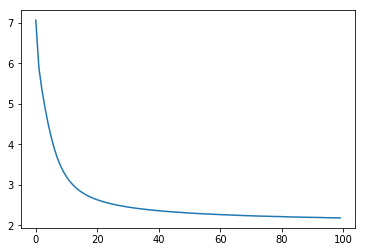

In [105]:
import matplotlib.pyplot as plt
plt.plot(l)
plt.show()

# gensim 数据接口

In [66]:
from gensim.models import word2vec # word2vec 模型
w2v_model = word2vec.Word2Vec(sentences,min_count=5,workers=50,size=100)

In [117]:
import numpy as np
from sklearn.preprocessing import normalize

def similar(v1,v2): 
    return np.dot(v1,v2) / (np.linalg.norm(v1)*(np.linalg.norm(v2)))

e = None

with open('./saved_files/e.pkl','rb') as f:
    e = pkl.load(f)
    e = e.weight.detach().cpu().numpy()
# e = normalize(e)
q = '动物'
print(e.shape)
s = {}
for w,i in word2index.items():
    s[w] = similar(e[i],e[word2index[q]])
s = sorted(s.items(),key=lambda x:x[1],reverse=True)[:10]
print(s)
print(w2v_model.wv.most_similar(q))

(19767, 100)
[('动物', 1.0), ('网路', 0.45104304), ('脊椎动物', 0.42363852), ('Club', 0.40397677), ('证书', 0.3995529), ('锻焊', 0.39632577), ('瓦', 0.3944327), ('御', 0.3888452), ('劳动力', 0.3882849), ('俩', 0.38493794)]
[('M8802', 0.9665425419807434), ('常见', 0.9658806920051575), ('两种', 0.9552369713783264), ('鸟类', 0.9476338028907776), ('灭绝', 0.9474760293960571), ('分类', 0.9388299584388733), ('原始', 0.937654972076416), ('属实', 0.9372254014015198), ('骨骼', 0.9371610283851624), ('特征', 0.9354689717292786)]


In [297]:
len(w2v_model.wv.vocab)

19767